In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils.load import load_raw_data_csv

### Load Data

In [ ]:
df = load_raw_data_csv("data/")
df.head()

### First Investigation
Check for the type of variables (contineous, categorical, etc.) and nan-values.

Results:
- It can be seen that circumplex.arousal and circumplex.valence are the only variables containing nan-values. Respectively about 1 and 3 percent of the total values for those variables.
- Some of the recorded screen times have negative values.
- Practically all variables related to screentime or activity have distributions skewed to the right. A possible solution might be transforming the data by taking the logarithm

In [103]:
for variable in df.variable.unique():
    values = df[df.variable == variable].value
    print(40*"%" + "\n" + variable + "\n", values.describe())

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
mood
 count    5641.000000
mean        6.992555
std         1.032769
min         1.000000
25%         7.000000
50%         7.000000
75%         8.000000
max        10.000000
Name: value, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
circumplex.arousal
 count    5597.000000
mean       -0.098624
std         1.051868
min        -2.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: value, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
circumplex.valence
 count    5487.000000
mean        0.687808
std         0.671298
min        -2.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: value, dtype: float64
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
activity
 count    22965.000000
mean         0.115958
std          0.186946
min          0.000000
25%          0.000000
50%          0.021739
75%          0.158333
max          1.000000
Name: value, dty

In [104]:
nan_df = pd.DataFrame(columns=["nan-count", "nan-pct"])
for i, variable in enumerate(df.variable.unique()):
    values = df[df.variable == variable].value
    nan_count = values.isna().sum()
    nan_pct = nan_count / len(values)
    nan_df.loc[variable] = [nan_count, nan_pct]
    
# only print those variables with nonzero nan-values
nan_df[nan_df["nan-count"] != 0]

,nan-count,nan-pct
circumplex.arousal,46.0,0.008152
circumplex.valence,156.0,0.027645


mood
 7.0     2588
8.0     1429
6.0     1009
5.0      258
9.0      215
4.0       92
3.0       17
10.0      17
2.0       13
1.0        3
Name: value, dtype: int64
circumplex.arousal
  1.0    1654
-1.0    1612
 0.0    1586
-2.0     521
 2.0     224
Name: value, dtype: int64
circumplex.valence
  1.0    3595
 0.0    1307
-1.0     289
 2.0     265
-2.0      31
Name: value, dtype: int64
call
 1.0    5239
Name: value, dtype: int64
sms
 1.0    1798
Name: value, dtype: int64
Variable: activity


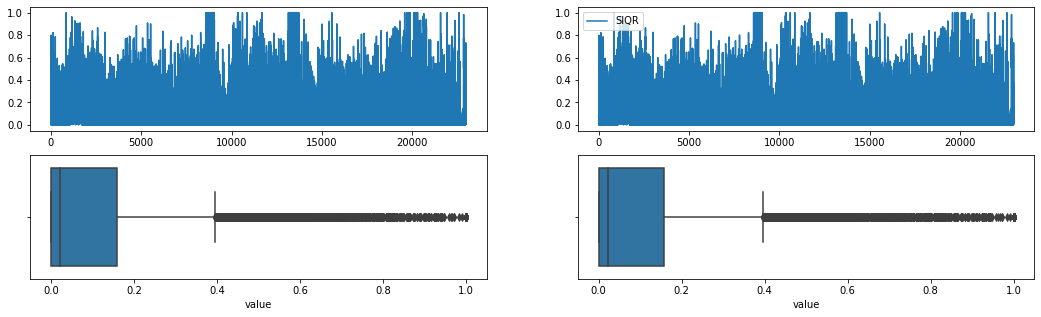

Variable: screen


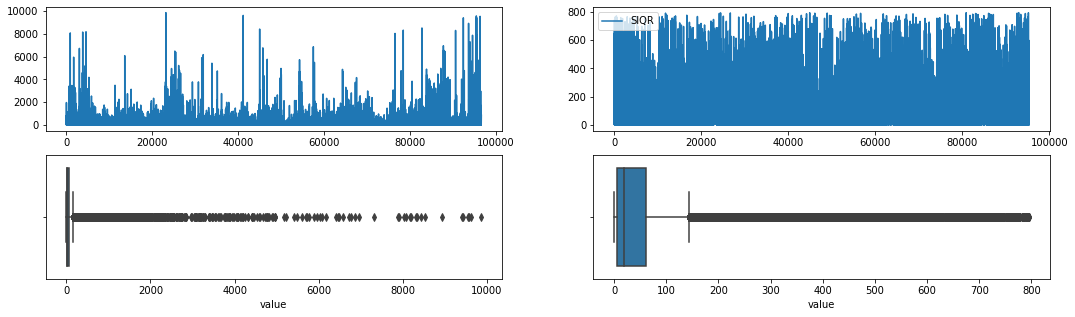

Variable: appCat.builtin


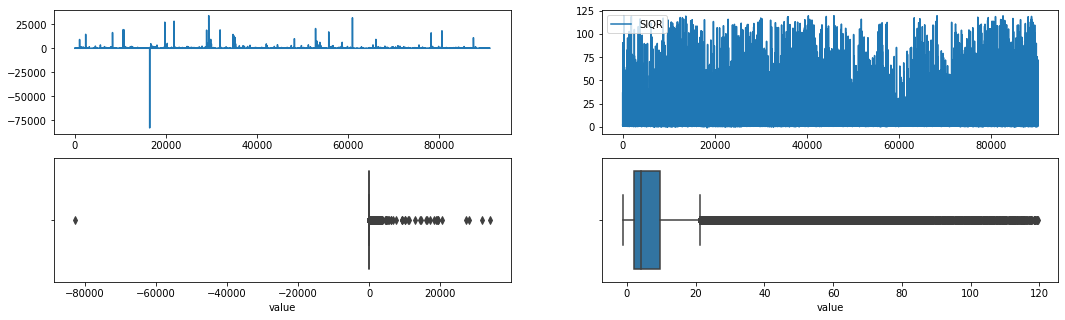

Variable: appCat.communication


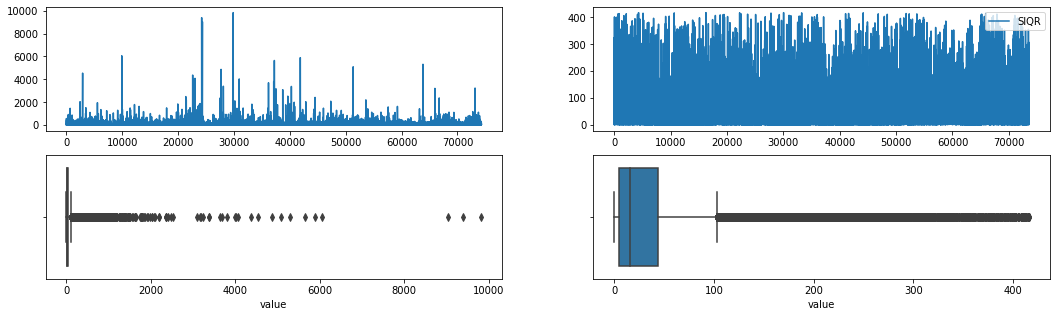

Variable: appCat.entertainment


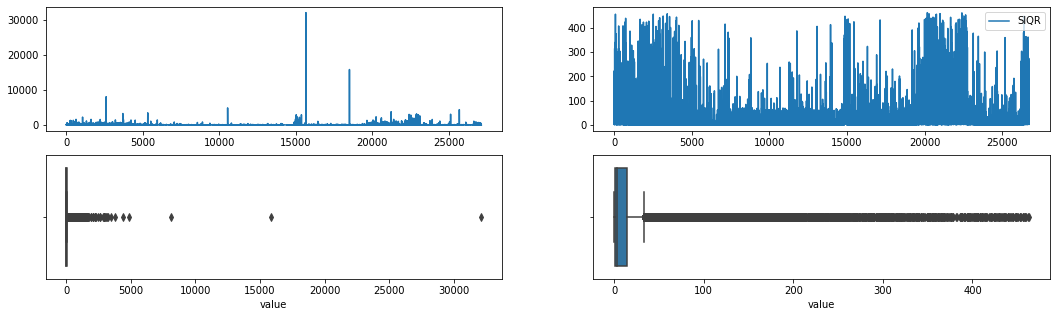

Variable: appCat.finance


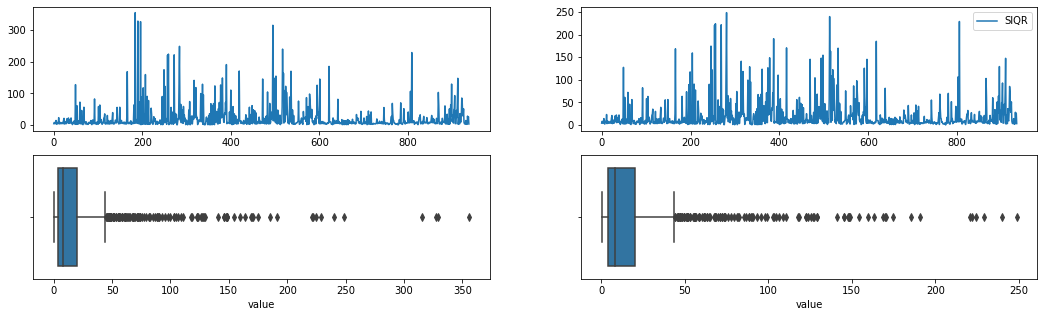

Variable: appCat.game


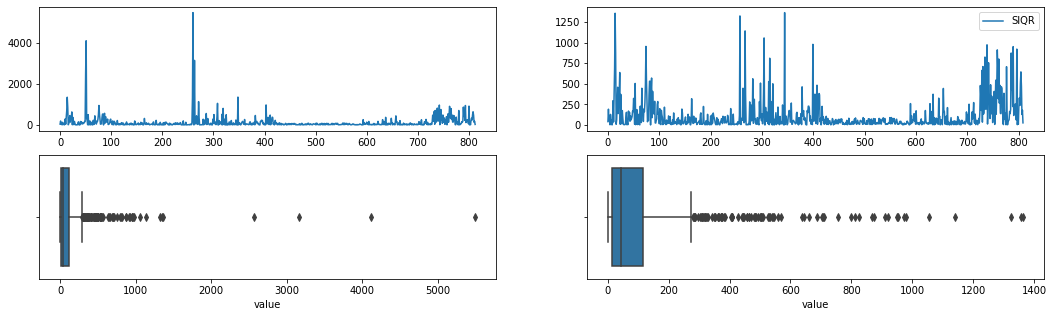

Variable: appCat.office


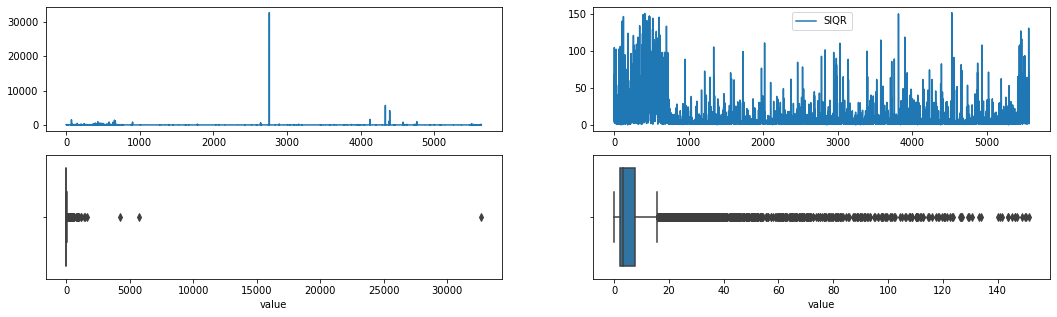

Variable: appCat.other


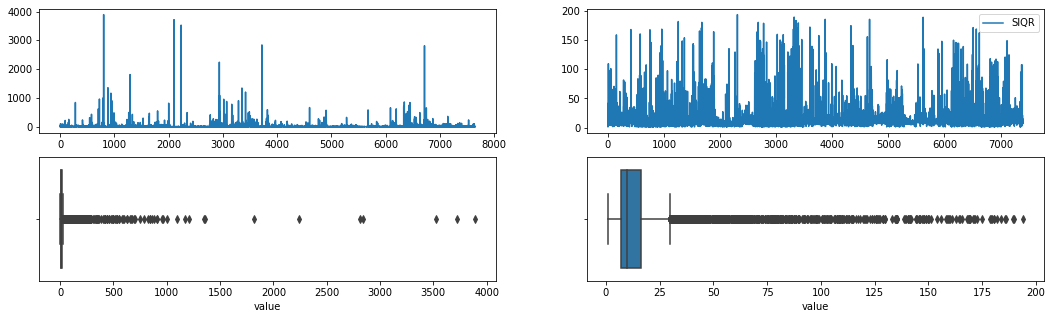

Variable: appCat.social


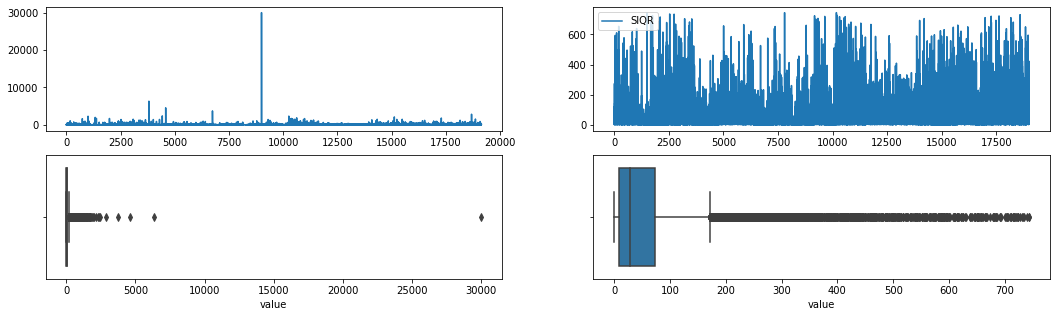

Variable: appCat.travel


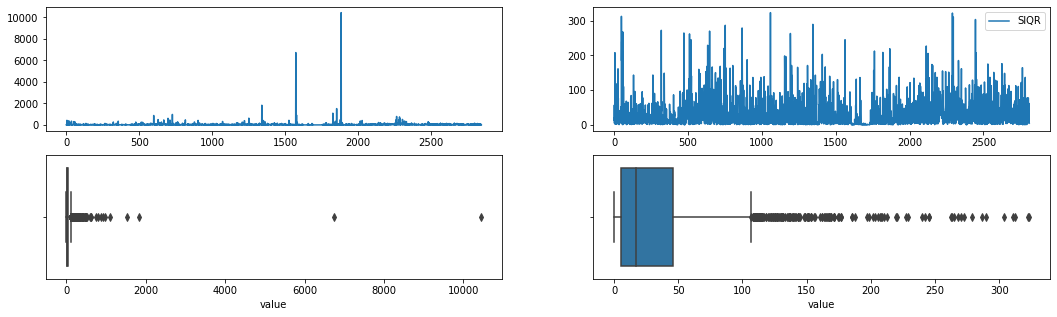

Variable: appCat.unknown


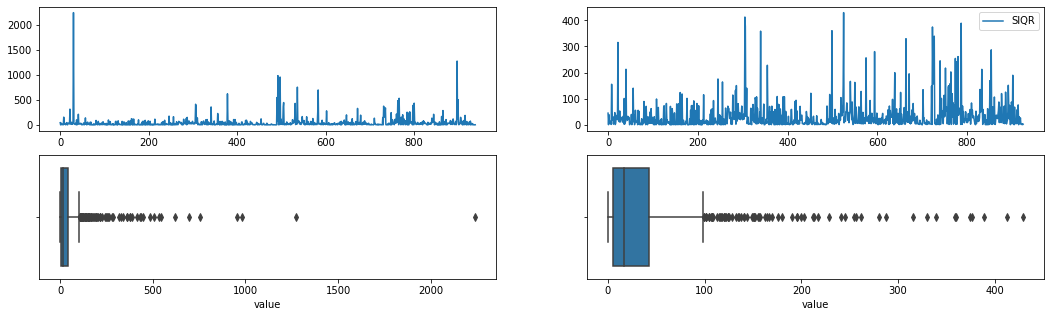

Variable: appCat.utilities


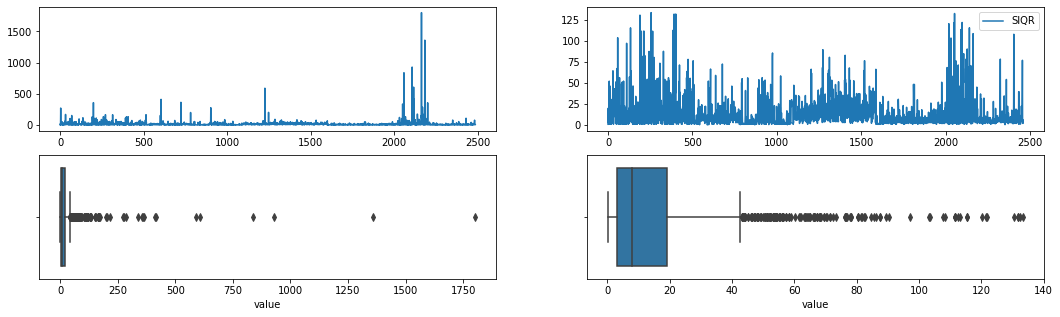

Variable: appCat.weather


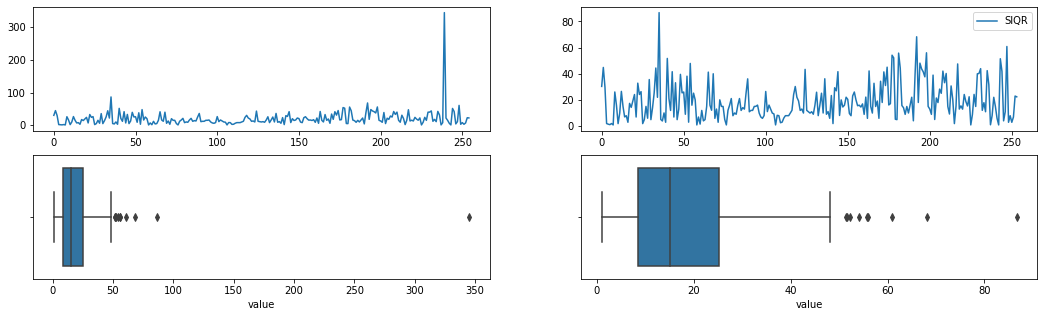

In [102]:
variables_to_plot_for = [var for var in list(df.variable.unique()) if "appCat." in var or var in ["screen", "activity"]]
variables_to_not_plot_for = set(df.variable.unique()) - set(variables_to_plot_for)

# for binary variables and/or limited to for example [-2,2]
for variable in variables_to_not_plot_for:
    print(variable + "\n", df[df.variable == variable].value.value_counts())

# all contineous variables (mostly screen time)
for variable in variables_to_plot_for:
    values = df[df.variable == variable].reset_index(drop=True).value
    data1 = sorted(values.values)
    q1 = np.percentile(data1, 25)
    q2 = np.percentile(data1, 50)
    q3 = np.percentile(data1, 95)

    values_outliers = values[~((values<(q2-3*(q2-q1))) | (values>(q2+3*(q3-q2))))].reset_index(drop=True)

    print('Variable: {}'.format(variable))
    fig, axs = plt.subplots(2,2, figsize=(18,5))
        
    # left plot
    ax = axs[0,0]
    # ax.set_title("")
    ax.plot(values, label='No correction')

    # right plot
    ax = axs[0,1]
    # ax.set_title("")
    ax.plot(values_outliers, label='SIQR')
    ax.legend()

    ax = axs[1,0]
    # ax.set_title("Boxplot all datapints")
    sns.boxplot(data=values, x=values, sym="red", ax=ax)

    ax = axs[1,1]
    sns.boxplot(data=values_outliers, x=values_outliers, ax=ax)

    for ax in axs:
        # ax.grid()
        # ax.set_title('{}'.format(var))
        pass
    plt.show()

### Simple Correlation Plots
Investigate the correlation between the variables. The values for each variables are aggregated by userId and date.
Then the correlation is computed. Nan-values are automatically ignored in this computation.
It can be seen that:
- screen time seems highly positively correlated to appCat.communication
- screen time is also positively correlated to gaming and social
- circumplex.valence is highly positvely correlated to mood
The aggregated variables related to screen time or call/sms are filled with nan-values. If these fields are not present for a full day, i.e. no screen time recorded, this implies zero.

type of aggregation: sum


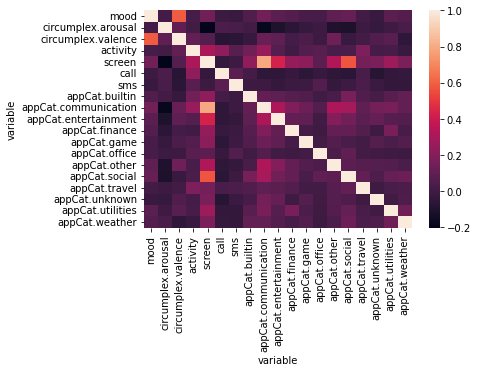

type of aggregation: mean


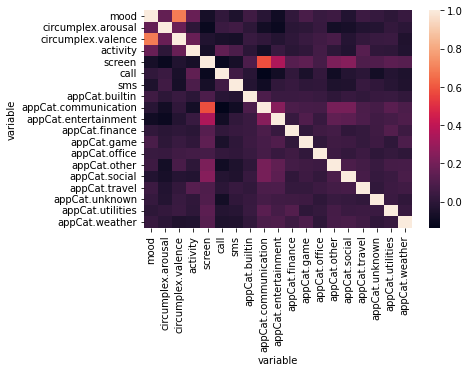

In [114]:
df_pivot = pd.pivot_table(df, values='value', index=['id', 'date'],
                                columns=['variable'], aggfunc=[np.sum, np.mean]).reset_index()
for multi_index in ["sum", "mean"]:
    for column in df_pivot[multi_index].columns:
        if "appCat." in column or column in ["screen", "call", "sms"]:
            df_pivot[multi_index, column] = df_pivot[multi_index, column].fillna(0)
            
# plot correlation map
for type_of_agg in ["sum", "mean"]:
    print("type of aggregation: " + type_of_agg)
    r = df_pivot[[[type_of_agg,c] for c in df.variable.unique()]][type_of_agg]
    sns.heatmap(r.corr())
    plt.show()